In [1]:
#! pip install overpy  
#! pip install routingpy
#! pip install gym
#! pip install tianshou
#! pip install ray
#! pip install torch
#! pip install scipy
#! pip install matplotlib

In [2]:
# Importing required libraries

import os 
import sys
import random
import argparse
from datetime import datetime
import warnings
warnings.simplefilter('ignore')


import gym
from gym import spaces

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import pickle

import torch
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter


In [3]:
sys.getrecursionlimit()

3000

In [4]:
# Modules from tianshou framework

import tianshou
from typing import Any, Callable, List, Optional, Tuple, Union, Dict
from tianshou.env import DummyVectorEnv
from tianshou.data import Batch, to_torch, to_torch_as
from tianshou.policy import BasePolicy
from tianshou.utils import TensorboardLogger


from tianshou.env.worker import (
    DummyEnvWorker,
    EnvWorker,
    RayEnvWorker,
    SubprocEnvWorker,
)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == "cuda":
    torch.cuda.get_device_properties(device)

In [6]:
# Derived modules and custom defined classes

from env.VRPEnv import VRPEnv
from policy.VRPPolicy import REINFORCEPolicy
from nets.attention_model import AttentionModel


from data.VRPCollector import Collector
from data.BufferManager import ReplayBuffer, VectorReplayBuffer
from policy.VRPtrainer import OnpolicyTrainer, onpolicy_trainer
from data.Graph_Viz import decode_buffer, generate_tours, plot_vehicle_routes

In [7]:
# Load the saved train and test graphs dataset
graph_size = 10
train_size = 10000
test_size = 5000

train_data_path = "./data/train/"+ f"train_graphs_{train_size}x10.pickle"
test_data_path = "./data/test/"+ f"test_graphs_{test_size}x10.pickle"

with open(train_data_path, 'rb') as train_handle:
    load_train_graphs = pickle.load(train_handle)
    
with open(test_data_path, 'rb') as test_handle:
    load_test_graphs = pickle.load(test_handle)  

In [8]:
# A peak into generated instances

print(f"# of Training graphs: {len(load_train_graphs)}")
print(f"# of Test graphs: {len(load_test_graphs)}")

n = 10
print("\n", load_train_graphs[n]["node_features"])
print("\n", load_test_graphs[n]["node_features"])

# of Training graphs: 10000
# of Test graphs: 5000

 tensor([[1.0000, 0.0000, 0.0000, 0.5469, 0.5050],
        [0.0000, 1.0000, 0.2600, 0.6069, 0.4661],
        [0.0000, 1.0000, 0.1700, 0.3745, 0.3965],
        [0.0000, 1.0000, 0.3400, 0.2832, 0.5073],
        [0.0000, 1.0000, 0.3800, 0.4615, 0.5906],
        [0.0000, 1.0000, 0.3700, 0.7753, 0.5376],
        [0.0000, 1.0000, 0.1300, 0.3504, 0.4703],
        [0.0000, 1.0000, 0.4400, 0.4587, 0.5080],
        [0.0000, 1.0000, 0.1900, 0.6147, 0.9906],
        [0.0000, 1.0000, 0.2300, 0.3759, 0.4604],
        [0.0000, 1.0000, 0.4800, 0.3809, 0.4205]])

 tensor([[1.0000, 0.0000, 0.0000, 0.4792, 0.4269],
        [0.0000, 1.0000, 0.2200, 0.4267, 0.6768],
        [0.0000, 1.0000, 0.1900, 0.3147, 0.4058],
        [0.0000, 1.0000, 0.3500, 0.4274, 0.5287],
        [0.0000, 1.0000, 0.2000, 0.6437, 0.1724],
        [0.0000, 1.0000, 0.1500, 0.2154, 0.5051],
        [0.0000, 1.0000, 0.4600, 0.3477, 0.4486],
        [0.0000, 1.0000, 0.1300, 0.5217, 0.3

In [9]:
# Setting up Vectorized environments for train and test datasets

train_envs = DummyVectorEnv([lambda instance=graph, idx=i: VRPEnv(instance, idx) for i,graph in enumerate(load_train_graphs)])
test_envs = DummyVectorEnv([lambda instance=graph, idx=i: VRPEnv(instance, idx) for i,graph in enumerate(load_test_graphs)])

In [10]:
# Training parameters

training_params = {
    "experiment_idx" : 104,
    
    # Optimization
    "learning_rate" : 0.000025,
    "betas" : (0.9, 0.99), # coefficients used for computing running averages of gradient and its square
    "weight_decay" : 0.005,  # weight decay coefficient for regularization
    "n_epochs" : 30,
    "batch_size" : 256,
    
    
    # Trainer and Collector setup
    "graph_size" : load_train_graphs[0]["node_features"].shape[0] - 1,
    "train_graphs" : len(load_train_graphs),
    "test_graphs" : len(load_test_graphs),
    "train_buffer_size" : 1000000,
    "test_buffer_size" : 1000000,
    "repeat_per_collect" : 1,
    "test_in_train" : True,
    
}

training_params["episode_per_collect"] = training_params["episode_per_test"] = training_params["train_graphs"]
training_params["step_per_epoch"] = training_params["graph_size"] * training_params["train_graphs"]
training_params

{'experiment_idx': 104,
 'learning_rate': 2.5e-05,
 'betas': (0.9, 0.99),
 'weight_decay': 0.005,
 'n_epochs': 30,
 'batch_size': 256,
 'graph_size': 10,
 'train_graphs': 10000,
 'test_graphs': 5000,
 'train_buffer_size': 1000000,
 'test_buffer_size': 1000000,
 'repeat_per_collect': 1,
 'test_in_train': True,
 'episode_per_collect': 10000,
 'episode_per_test': 10000,
 'step_per_epoch': 100000}

In [11]:
# Setup Model, Optimizer and Policy (Agent) 

model = AttentionModel(
        embedding_dim=64,
        hidden_dim=16,
        graph_size = training_params["graph_size"],
        n_encode_layers=2,
        tanh_clipping=10.,
        mask_inner=True, 
        mask_logits=True,
        normalization='batch',
        n_heads=8,
        checkpoint_encoder=False,
        shrink_size=None)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optim = torch.optim.AdamW(
        model.parameters(), 
        lr=training_params["learning_rate"],
        betas=training_params["betas"], 
        weight_decay=training_params["weight_decay"],
        eps=1e-08)


VRPpolicy = REINFORCEPolicy(model, optim)

In [12]:
# Setting up Replay Buffers and Collectors

test_replaybuffer = VectorReplayBuffer(training_params["test_buffer_size"], buffer_num=training_params["test_graphs"])
train_replaybuffer = VectorReplayBuffer(training_params["train_buffer_size"], buffer_num=training_params["train_graphs"])

test_collector = Collector(VRPpolicy, test_envs, test_replaybuffer)
train_collector = Collector(VRPpolicy, train_envs, train_replaybuffer)

Collector reset!
Collector reset!


In [13]:
# Setting up trainer 

logdir = "./logs/"
exp_num = training_params["experiment_idx"]

# Setup Tensorboard logger
log_path = os.path.join(logdir, f"VRPtraining_exp{exp_num}")
writer = SummaryWriter(log_path)
logger = TensorboardLogger(writer)


train_collector.reset()
test_collector.reset()
train_replaybuffer.reset()
test_replaybuffer.reset()

trainer = OnpolicyTrainer(
    VRPpolicy,
    train_collector,
    test_collector,
    max_epoch = training_params["n_epochs"],
    step_per_epoch = training_params["step_per_epoch"],
    repeat_per_collect = training_params["repeat_per_collect"],
    episode_per_test = training_params["episode_per_test"],
    episode_per_collect = training_params["episode_per_collect"],
    batch_size = training_params["batch_size"],
    logger=logger)

Collector reset!
Collector reset!


In [14]:
# Train the model and store epoch stats in a dataframe

losses = []
train_stat = []

for epoch, epoch_stat, info in trainer:
    print("Epoch:", epoch)
    print(epoch_stat)
    print("\n")
    #print(info)
    losses.append(-epoch_stat["loss"])
    epoch_stat["epoch"] = epoch
    train_stat.append(epoch_stat)
    
train_df_cols = epoch_stat.keys()
train_df = pd.DataFrame(train_stat, columns = train_df_cols)
#train_df

Epoch #1: 129569it [00:53, 2424.13it/s, bl_rew=78.11, env_step=129569, len=12, loss=-121.748, n/ep=10000, n/st=129569, rew=107.89]


Epoch #1: test_reward: 109.878345 ± 26.242150, best_reward: 106.623663 ± 24.557543 in #0
Epoch: 1
{'test_reward': 109.8783452, 'test_reward_std': 26.242149822224338, 'best_reward': 106.62366298, 'best_reward_std': 24.557542980627105, 'best_epoch': 0, 'loss': -121.74750923156738, 'gradient_step': 506, 'env_step': 129569, 'rew': 107.89272412000001, 'bl_rew': 78.11131017999999, 'len': 12, 'n/ep': 10000, 'n/st': 129569}




Epoch #2: 129641it [00:52, 2471.00it/s, bl_rew=78.11, env_step=259210, len=12, loss=-91.831, n/ep=10000, n/st=129641, rew=109.50]


Epoch #2: test_reward: 111.085908 ± 27.134823, best_reward: 106.623663 ± 24.557543 in #0
Epoch: 2
{'test_reward': 111.08590825999998, 'test_reward_std': 27.13482255876721, 'best_reward': 106.62366298, 'best_reward_std': 24.557542980627105, 'best_epoch': 0, 'loss': -91.83076099395753, 'gradient_step': 1012, 'env_step': 259210, 'rew': 109.49719065000001, 'bl_rew': 78.11131017999999, 'len': 12, 'n/ep': 10000, 'n/st': 129641}




Epoch #3: 130640it [00:52, 2479.05it/s, bl_rew=78.11, env_step=389850, len=13, loss=-177.827, n/ep=10000, n/st=130640, rew=110.89]


Epoch #3: test_reward: 105.350171 ± 25.057833, best_reward: 105.350171 ± 25.057833 in #3
Epoch: 3
{'test_reward': 105.3501713, 'test_reward_std': 25.05783347064152, 'best_reward': 105.3501713, 'best_reward_std': 25.05783347064152, 'best_epoch': 3, 'loss': -177.8274383544922, 'gradient_step': 1522, 'env_step': 389850, 'rew': 110.88921300999999, 'bl_rew': 78.11131017999999, 'len': 13, 'n/ep': 10000, 'n/st': 130640}




Epoch #4: 129807it [00:51, 2518.04it/s, bl_rew=78.11, env_step=519657, len=12, loss=-63.414, n/ep=10000, n/st=129807, rew=105.63]


Epoch #4: test_reward: 113.702236 ± 28.152722, best_reward: 105.350171 ± 25.057833 in #3
Epoch: 4
{'test_reward': 113.70223576, 'test_reward_std': 28.152722050866437, 'best_reward': 105.3501713, 'best_reward_std': 25.05783347064152, 'best_epoch': 3, 'loss': -63.41420684814453, 'gradient_step': 2029, 'env_step': 519657, 'rew': 105.63492522, 'bl_rew': 78.11131017999999, 'len': 12, 'n/ep': 10000, 'n/st': 129807}




Epoch #5: 130626it [00:51, 2513.42it/s, bl_rew=78.11, env_step=650283, len=13, loss=-109.419, n/ep=10000, n/st=130626, rew=113.44]


Epoch #5: test_reward: 106.174680 ± 25.749970, best_reward: 105.350171 ± 25.057833 in #3
Epoch: 5
{'test_reward': 106.17467966, 'test_reward_std': 25.74996991211975, 'best_reward': 105.3501713, 'best_reward_std': 25.05783347064152, 'best_epoch': 3, 'loss': -109.41878604888916, 'gradient_step': 2539, 'env_step': 650283, 'rew': 113.43621727999998, 'bl_rew': 78.11131018, 'len': 13, 'n/ep': 10000, 'n/st': 130626}




Epoch #6: 130006it [00:51, 2536.59it/s, bl_rew=78.11, env_step=780289, len=13, loss=-46.576, n/ep=10000, n/st=130006, rew=105.87]


Epoch #6: test_reward: 108.204320 ± 27.415812, best_reward: 105.350171 ± 25.057833 in #3
Epoch: 6
{'test_reward': 108.2043199, 'test_reward_std': 27.415811838102222, 'best_reward': 105.3501713, 'best_reward_std': 25.05783347064152, 'best_epoch': 3, 'loss': -46.576092357635495, 'gradient_step': 3046, 'env_step': 780289, 'rew': 105.86624117999999, 'bl_rew': 78.11131017999999, 'len': 13, 'n/ep': 10000, 'n/st': 130006}




Epoch #7: 129922it [00:51, 2524.32it/s, bl_rew=78.11, env_step=910211, len=12, loss=-101.437, n/ep=10000, n/st=129922, rew=107.73]


Epoch #7: test_reward: 102.824374 ± 24.827165, best_reward: 102.824374 ± 24.827165 in #7
Epoch: 7
{'test_reward': 102.82437396, 'test_reward_std': 24.82716524543086, 'best_reward': 102.82437396, 'best_reward_std': 24.82716524543086, 'best_epoch': 7, 'loss': -101.43694030761719, 'gradient_step': 3553, 'env_step': 910211, 'rew': 107.72942428000002, 'bl_rew': 78.11131018, 'len': 12, 'n/ep': 10000, 'n/st': 129922}




Epoch #8: 129754it [00:52, 2483.08it/s, bl_rew=78.11, env_step=1039965, len=12, loss=-55.977, n/ep=10000, n/st=129754, rew=103.25]


Epoch #8: test_reward: 100.142739 ± 27.723883, best_reward: 100.142739 ± 27.723883 in #8
Epoch: 8
{'test_reward': 100.14273894, 'test_reward_std': 27.723883464518273, 'best_reward': 100.14273894, 'best_reward_std': 27.723883464518273, 'best_epoch': 8, 'loss': -55.976720008850094, 'gradient_step': 4059, 'env_step': 1039965, 'rew': 103.25210704999999, 'bl_rew': 78.11131018, 'len': 12, 'n/ep': 10000, 'n/st': 129754}




Epoch #9: 129713it [00:51, 2539.38it/s, bl_rew=78.11, env_step=1169678, len=12, loss=-65.847, n/ep=10000, n/st=129713, rew=100.32]


Epoch #9: test_reward: 110.653055 ± 29.290365, best_reward: 100.142739 ± 27.723883 in #8
Epoch: 9
{'test_reward': 110.65305538000001, 'test_reward_std': 29.29036545076082, 'best_reward': 100.14273894, 'best_reward_std': 27.723883464518273, 'best_epoch': 8, 'loss': -65.84714431762696, 'gradient_step': 4565, 'env_step': 1169678, 'rew': 100.31506087999999, 'bl_rew': 78.11131017999999, 'len': 12, 'n/ep': 10000, 'n/st': 129713}




Epoch #10: 129596it [00:51, 2531.33it/s, bl_rew=78.11, env_step=1299274, len=12, loss=-98.275, n/ep=10000, n/st=129596, rew=110.23]


Epoch #10: test_reward: 98.463466 ± 24.610580, best_reward: 98.463466 ± 24.610580 in #10
Epoch: 10
{'test_reward': 98.46346640000002, 'test_reward_std': 24.610579632921514, 'best_reward': 98.46346640000002, 'best_reward_std': 24.610579632921514, 'best_epoch': 10, 'loss': -98.27487888336182, 'gradient_step': 5071, 'env_step': 1299274, 'rew': 110.23129506999999, 'bl_rew': 78.11131017999999, 'len': 12, 'n/ep': 10000, 'n/st': 129596}




Epoch #11: 129788it [00:50, 2545.76it/s, bl_rew=78.11, env_step=1429062, len=12, loss=-22.659, n/ep=10000, n/st=129788, rew=97.60]


Epoch #11: test_reward: 100.966105 ± 25.055039, best_reward: 98.463466 ± 24.610580 in #10
Epoch: 11
{'test_reward': 100.96610530000001, 'test_reward_std': 25.05503922242785, 'best_reward': 98.46346640000002, 'best_reward_std': 24.610579632921514, 'best_epoch': 10, 'loss': -22.658677453994752, 'gradient_step': 5577, 'env_step': 1429062, 'rew': 97.60089761, 'bl_rew': 78.11131018, 'len': 12, 'n/ep': 10000, 'n/st': 129788}




Epoch #12: 129777it [00:52, 2494.62it/s, bl_rew=78.11, env_step=1558839, len=12, loss=-79.387, n/ep=10000, n/st=129777, rew=100.95]


Epoch #12: test_reward: 96.961911 ± 25.151047, best_reward: 96.961911 ± 25.151047 in #12
Epoch: 12
{'test_reward': 96.96191082, 'test_reward_std': 25.151046597540486, 'best_reward': 96.96191082, 'best_reward_std': 25.151046597540486, 'best_epoch': 12, 'loss': -79.38671657562256, 'gradient_step': 6083, 'env_step': 1558839, 'rew': 100.95106331, 'bl_rew': 78.11131017999999, 'len': 12, 'n/ep': 10000, 'n/st': 129777}




Epoch #13: 129666it [00:53, 2427.49it/s, bl_rew=78.11, env_step=1688505, len=12, loss=-63.223, n/ep=10000, n/st=129666, rew=97.02]


Epoch #13: test_reward: 110.246671 ± 28.846224, best_reward: 96.961911 ± 25.151047 in #12
Epoch: 13
{'test_reward': 110.24667113999999, 'test_reward_std': 28.84622439382834, 'best_reward': 96.96191082, 'best_reward_std': 25.151046597540486, 'best_epoch': 12, 'loss': -63.22259313583374, 'gradient_step': 6589, 'env_step': 1688505, 'rew': 97.02026707000002, 'bl_rew': 78.11131018, 'len': 12, 'n/ep': 10000, 'n/st': 129666}




Epoch #14: 129744it [00:52, 2489.05it/s, bl_rew=78.11, env_step=1818249, len=12, loss=-170.169, n/ep=10000, n/st=129744, rew=110.11]


Epoch #14: test_reward: 97.266869 ± 24.949202, best_reward: 96.961911 ± 25.151047 in #12
Epoch: 14
{'test_reward': 97.26686938, 'test_reward_std': 24.949202322476292, 'best_reward': 96.96191082, 'best_reward_std': 25.151046597540486, 'best_epoch': 12, 'loss': -170.16889015197754, 'gradient_step': 7095, 'env_step': 1818249, 'rew': 110.11401778, 'bl_rew': 78.11131018, 'len': 12, 'n/ep': 10000, 'n/st': 129744}




Epoch #15: 129723it [00:53, 2414.09it/s, bl_rew=78.11, env_step=1947972, len=12, loss=-61.347, n/ep=10000, n/st=129723, rew=96.58]


Epoch #15: test_reward: 109.724036 ± 28.304761, best_reward: 96.961911 ± 25.151047 in #12
Epoch: 15
{'test_reward': 109.72403584, 'test_reward_std': 28.304760848697583, 'best_reward': 96.96191082, 'best_reward_std': 25.151046597540486, 'best_epoch': 12, 'loss': -61.3472269821167, 'gradient_step': 7601, 'env_step': 1947972, 'rew': 96.58040813, 'bl_rew': 78.11131018, 'len': 12, 'n/ep': 10000, 'n/st': 129723}




Epoch #16: 129666it [00:52, 2454.57it/s, bl_rew=78.11, env_step=2077638, len=12, loss=-171.838, n/ep=10000, n/st=129666, rew=110.00]


Epoch #16: test_reward: 97.923395 ± 25.174286, best_reward: 96.961911 ± 25.151047 in #12
Epoch: 16
{'test_reward': 97.92339488, 'test_reward_std': 25.174285539279516, 'best_reward': 96.96191082, 'best_reward_std': 25.151046597540486, 'best_epoch': 12, 'loss': -171.83830520629883, 'gradient_step': 8107, 'env_step': 2077638, 'rew': 110.00160213, 'bl_rew': 78.11131017999999, 'len': 12, 'n/ep': 10000, 'n/st': 129666}




Epoch #17: 129735it [00:53, 2446.22it/s, bl_rew=78.11, env_step=2207373, len=12, loss=-48.235, n/ep=10000, n/st=129735, rew=97.60]


Epoch #17: test_reward: 104.488696 ± 25.473626, best_reward: 96.961911 ± 25.151047 in #12
Epoch: 17
{'test_reward': 104.48869638000001, 'test_reward_std': 25.473625556388097, 'best_reward': 96.96191082, 'best_reward_std': 25.151046597540486, 'best_epoch': 12, 'loss': -48.234826164245604, 'gradient_step': 8613, 'env_step': 2207373, 'rew': 97.59503054999999, 'bl_rew': 78.11131018, 'len': 12, 'n/ep': 10000, 'n/st': 129735}




Epoch #18: 129959it [00:52, 2464.94it/s, bl_rew=78.11, env_step=2337332, len=12, loss=-70.307, n/ep=10000, n/st=129959, rew=104.21]


Epoch #18: test_reward: 101.673953 ± 24.736401, best_reward: 96.961911 ± 25.151047 in #12
Epoch: 18
{'test_reward': 101.67395280000001, 'test_reward_std': 24.73640093023292, 'best_reward': 96.96191082, 'best_reward_std': 25.151046597540486, 'best_epoch': 12, 'loss': -70.30738418579102, 'gradient_step': 9120, 'env_step': 2337332, 'rew': 104.2096876, 'bl_rew': 78.11131018, 'len': 12, 'n/ep': 10000, 'n/st': 129959}




Epoch #19: 129775it [00:52, 2469.81it/s, bl_rew=78.11, env_step=2467107, len=12, loss=-59.858, n/ep=10000, n/st=129775, rew=101.43]


Epoch #19: test_reward: 105.372613 ± 25.701373, best_reward: 96.961911 ± 25.151047 in #12
Epoch: 19
{'test_reward': 105.37261269999999, 'test_reward_std': 25.701372608343718, 'best_reward': 96.96191082, 'best_reward_std': 25.151046597540486, 'best_epoch': 12, 'loss': -59.8581464099884, 'gradient_step': 9626, 'env_step': 2467107, 'rew': 101.43091208999999, 'bl_rew': 78.11131017999999, 'len': 12, 'n/ep': 10000, 'n/st': 129775}




Epoch #20: 129895it [00:52, 2460.89it/s, bl_rew=78.11, env_step=2597002, len=12, loss=-55.750, n/ep=10000, n/st=129895, rew=104.23]


Epoch #20: test_reward: 111.329647 ± 28.089414, best_reward: 96.961911 ± 25.151047 in #12
Epoch: 20
{'test_reward': 111.32964714000002, 'test_reward_std': 28.089413998419754, 'best_reward': 96.96191082, 'best_reward_std': 25.151046597540486, 'best_epoch': 12, 'loss': -55.75001344680786, 'gradient_step': 10133, 'env_step': 2597002, 'rew': 104.23274312000001, 'bl_rew': 78.11131017999999, 'len': 12, 'n/ep': 10000, 'n/st': 129895}




Epoch #21: 129993it [00:52, 2485.27it/s, bl_rew=78.11, env_step=2726995, len=12, loss=-198.478, n/ep=10000, n/st=129993, rew=111.58]


Epoch #21: test_reward: 103.148343 ± 25.629850, best_reward: 96.961911 ± 25.151047 in #12
Epoch: 21
{'test_reward': 103.14834332, 'test_reward_std': 25.62984972739691, 'best_reward': 96.96191082, 'best_reward_std': 25.151046597540486, 'best_epoch': 12, 'loss': -198.47824508666992, 'gradient_step': 10640, 'env_step': 2726995, 'rew': 111.57898384999999, 'bl_rew': 78.11131017999999, 'len': 12, 'n/ep': 10000, 'n/st': 129993}




Epoch #22: 129705it [00:52, 2467.20it/s, bl_rew=78.11, env_step=2856700, len=12, loss=-55.002, n/ep=10000, n/st=129705, rew=102.79]


Epoch #22: test_reward: 98.966874 ± 23.668550, best_reward: 96.961911 ± 25.151047 in #12
Epoch: 22
{'test_reward': 98.96687383999999, 'test_reward_std': 23.66854973910619, 'best_reward': 96.96191082, 'best_reward_std': 25.151046597540486, 'best_epoch': 12, 'loss': -55.00185277938843, 'gradient_step': 11146, 'env_step': 2856700, 'rew': 102.78866645999999, 'bl_rew': 78.11131018, 'len': 12, 'n/ep': 10000, 'n/st': 129705}




Epoch #23: 129507it [00:52, 2486.28it/s, bl_rew=78.11, env_step=2986207, len=12, loss=-54.603, n/ep=10000, n/st=129507, rew=98.48]


Epoch #23: test_reward: 105.843140 ± 25.733857, best_reward: 96.961911 ± 25.151047 in #12
Epoch: 23
{'test_reward': 105.84314032, 'test_reward_std': 25.733857087129287, 'best_reward': 96.96191082, 'best_reward_std': 25.151046597540486, 'best_epoch': 12, 'loss': -54.602982177734376, 'gradient_step': 11651, 'env_step': 2986207, 'rew': 98.47959631999998, 'bl_rew': 78.11131017999999, 'len': 12, 'n/ep': 10000, 'n/st': 129507}




Epoch #24: 130131it [00:52, 2500.70it/s, bl_rew=78.11, env_step=3116338, len=13, loss=-109.417, n/ep=10000, n/st=130131, rew=105.42]


Epoch #24: test_reward: 100.496082 ± 24.415153, best_reward: 96.961911 ± 25.151047 in #12
Epoch: 24
{'test_reward': 100.49608202, 'test_reward_std': 24.415153229848602, 'best_reward': 96.96191082, 'best_reward_std': 25.151046597540486, 'best_epoch': 12, 'loss': -109.41749183654785, 'gradient_step': 12159, 'env_step': 3116338, 'rew': 105.42479398, 'bl_rew': 78.11131017999999, 'len': 13, 'n/ep': 10000, 'n/st': 130131}




Epoch #25: 129758it [00:52, 2494.87it/s, bl_rew=78.11, env_step=3246096, len=12, loss=-77.674, n/ep=10000, n/st=129758, rew=99.99]


Epoch #25: test_reward: 102.505693 ± 26.860813, best_reward: 96.961911 ± 25.151047 in #12
Epoch: 25
{'test_reward': 102.50569322, 'test_reward_std': 26.860813366931986, 'best_reward': 96.96191082, 'best_reward_std': 25.151046597540486, 'best_epoch': 12, 'loss': -77.67389636993408, 'gradient_step': 12665, 'env_step': 3246096, 'rew': 99.99263925, 'bl_rew': 78.11131018, 'len': 12, 'n/ep': 10000, 'n/st': 129758}




Epoch #26: 129704it [00:52, 2483.78it/s, bl_rew=78.11, env_step=3375800, len=12, loss=-71.166, n/ep=10000, n/st=129704, rew=102.06]


Epoch #26: test_reward: 98.499048 ± 26.359719, best_reward: 96.961911 ± 25.151047 in #12
Epoch: 26
{'test_reward': 98.49904828000001, 'test_reward_std': 26.35971897276693, 'best_reward': 96.96191082, 'best_reward_std': 25.151046597540486, 'best_epoch': 12, 'loss': -71.1657861328125, 'gradient_step': 13171, 'env_step': 3375800, 'rew': 102.05795673, 'bl_rew': 78.11131018, 'len': 12, 'n/ep': 10000, 'n/st': 129704}




Epoch #27: 129655it [00:52, 2485.05it/s, bl_rew=78.11, env_step=3505455, len=12, loss=-8.908, n/ep=10000, n/st=129655, rew=97.58]


Epoch #27: test_reward: 97.161827 ± 25.408698, best_reward: 96.961911 ± 25.151047 in #12
Epoch: 27
{'test_reward': 97.16182692, 'test_reward_std': 25.408698415563507, 'best_reward': 96.96191082, 'best_reward_std': 25.151046597540486, 'best_epoch': 12, 'loss': -8.908301126956939, 'gradient_step': 13677, 'env_step': 3505455, 'rew': 97.57571813, 'bl_rew': 78.11131018, 'len': 12, 'n/ep': 10000, 'n/st': 129655}




Epoch #28: 129682it [00:52, 2486.49it/s, bl_rew=78.11, env_step=3635137, len=12, loss=-39.474, n/ep=10000, n/st=129682, rew=96.97]


Epoch #28: test_reward: 98.508894 ± 25.270373, best_reward: 96.961911 ± 25.151047 in #12
Epoch: 28
{'test_reward': 98.50889414, 'test_reward_std': 25.270372515361696, 'best_reward': 96.96191082, 'best_reward_std': 25.151046597540486, 'best_epoch': 12, 'loss': -39.47365618705749, 'gradient_step': 14183, 'env_step': 3635137, 'rew': 96.96954815, 'bl_rew': 78.11131018, 'len': 12, 'n/ep': 10000, 'n/st': 129682}




Epoch #29: 129862it [00:51, 2542.52it/s, bl_rew=78.11, env_step=3764999, len=12, loss=-76.446, n/ep=10000, n/st=129862, rew=98.41]


Epoch #29: test_reward: 90.470408 ± 23.438057, best_reward: 90.470408 ± 23.438057 in #29
Epoch: 29
{'test_reward': 90.47040794, 'test_reward_std': 23.438057231633405, 'best_reward': 90.47040794, 'best_reward_std': 23.438057231633405, 'best_epoch': 29, 'loss': -76.44623111724853, 'gradient_step': 14690, 'env_step': 3764999, 'rew': 98.40909488999999, 'bl_rew': 78.11131018, 'len': 12, 'n/ep': 10000, 'n/st': 129862}




Epoch #30: 129715it [00:52, 2455.83it/s, bl_rew=78.11, env_step=3894714, len=12, loss=-2.015, n/ep=10000, n/st=129715, rew=90.42]


Epoch #30: test_reward: 89.804985 ± 22.609892, best_reward: 89.804985 ± 22.609892 in #30
Epoch: 30
{'test_reward': 89.80498517999999, 'test_reward_std': 22.609892114057565, 'best_reward': 89.80498517999999, 'best_reward_std': 22.609892114057565, 'best_epoch': 30, 'loss': -2.0148668003082277, 'gradient_step': 15196, 'env_step': 3894714, 'rew': 90.41550611000001, 'bl_rew': 78.11131018, 'len': 12, 'n/ep': 10000, 'n/st': 129715}




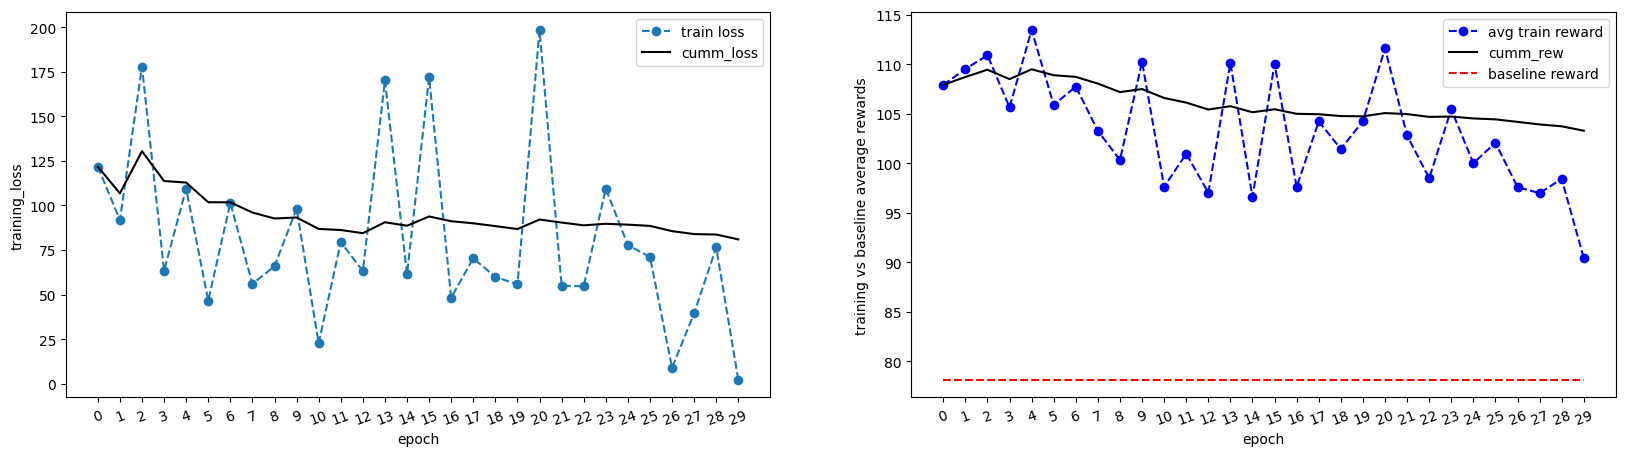

In [15]:
# Plotting training loss and avg rewards over iterations

n_epochs = training_params["n_epochs"]
train_df["loss"] = losses
x = [e for e in range (n_epochs)]
default_x_ticks = range(len(x))
fig = plt.figure(figsize=(20 ,5))


plt.subplot(121)
train_df["loss"].plot(style='o--', label="train loss")
train_df['loss'].expanding().mean().plot(style='k-', label="cumm_loss")
plt.legend()
plt.xlabel("epoch")
plt.xticks(default_x_ticks, x, rotation=20)
plt.ylabel("training_loss")


plt.subplot(122)
train_df["rew"].plot(style='bo--', label="avg train reward")
train_df['rew'].expanding().mean().plot(style='k-', label="cumm_rew")
train_df["bl_rew"].plot(style='r--', label="baseline reward")
plt.xlabel("epoch")
plt.xticks(default_x_ticks, x, rotation=20)
plt.ylabel("training vs baseline average rewards")


plt.legend()
plt.show()

In [ ]:
# Perform train and test collections on the trained model

train_result = train_collector.collect(n_episode=len(load_train_graphs))
test_result = test_collector.collect(n_episode=len(load_test_graphs))
print(test_result)
train_df

In [ ]:
test_result

In [ ]:
# Studying and Plotting collected train and test solutions (distance values are abs(rewards))

def get_distances(rewards):
    distances = np.array([round(abs(rew),3) for rew in rewards])
    return distances


# Get computed distance values from the reward list
test_distances = get_distances(test_result["rews"])
test_bl_distances = get_distances(test_result["bl_rews"])

train_distances = get_distances(train_result["rews"])
train_bl_distances = get_distances(train_result["bl_rews"])

In [ ]:
avg_test_rew, best_test_rew  = round(np.mean(test_distances, axis=0),3), np.min(test_distances, axis=0)
avg_test_rew_bl, best_test_rew_bl = round(np.mean(test_bl_distances, axis=0),3), np.min(test_bl_distances, axis=0)


avg_train_rew, best_train_rew  = round(np.mean(train_distances, axis=0),3), np.min(train_distances, axis=0)
avg_train_rew_bl, best_train_rew_bl = round(np.mean(train_bl_distances, axis=0),3), np.min(train_bl_distances, axis=0)


print("TEST RESULTS")
print(f"Mean test reward: {avg_test_rew}")
print(f"Best test reward: {best_test_rew}")
print(f"\nMean baseline reward: {avg_test_rew_bl}")
print(f"Best baseline reward: {best_test_rew_bl}")

print("\n----------------\n")
print("TRAIN RESULTS")
print(f"Mean train reward: {avg_train_rew}")
print(f"Best train reward: {best_train_rew}")
print(f"\nMean baseline reward: {avg_train_rew_bl}")
print(f"Best baseline reward: {best_train_rew_bl}")

In [ ]:
# Plotting test and train distance values

fig = plt.figure(figsize=(15 ,8))

pd.Series(train_distances).plot.kde(style='b-', label="train rewards")
pd.Series(test_distances).plot.kde(style='r-', label="test rewards")

pd.Series(train_bl_distances).plot.kde(style='b--', label="train baseline rewards")
pd.Series(test_bl_distances).plot.kde(style='r--', label="test baseline rewards")

plt.xlabel("Distance")
plt.ylabel("Probability Density")
plt.title("Model vs Baseline Distances (Test/Train)", size=16)
plt.legend()

In [ ]:
# Gap between test distances and corresponding baseline solutions
fig = plt.figure(figsize=(8 ,5)) 

gaps = []
for i, dist in enumerate(test_distances):
    gap = (test_distances[i] - test_bl_distances[i]) / test_bl_distances[i]
    gaps.append(gap)
    
    
gaps = np.sort(np.array(gaps))
plt.hist(gaps, bins=10)
#plt.plot(base)

plt.xlabel("Sorting index")
plt.ylabel("Gap % vs Greedy Baseline")
plt.title("Test Distances Gap", size=16)
plt.legend()

In [ ]:
test_distances

In [ ]:
test_buffer_df = decode_buffer(test_replaybuffer)
#train_buffer_df = decode_buffer(train_replaybuffer)
test_buffer_df

In [ ]:
test_buffer_df.head(50)

In [ ]:
#train_rewards_df = train_buffer_df.groupby(['env_id']).agg(action_count=('action', 'count'), 
#                                        reward=('reward', 'sum'), 
#                                       bl_reward=('bl_reward', 'sum'))
#
#train_rewards_df

In [ ]:
test_rewards_df = test_buffer_df.groupby(['env_id']).agg(action_count=('action', 'count'), 
                                        reward=('reward', 'sum'), 
                                       bl_reward=('bl_reward', 'sum'))


test_rewards_df["avg_reward"] = test_rewards_df["reward"] * training_params["graph_size"] / test_rewards_df["action_count"]
test_rewards_df["avg_bl_reward"] = test_rewards_df["bl_reward"] * training_params["graph_size"] / test_rewards_df["action_count"]
test_rewards_df["reward_gap"] = test_rewards_df["avg_reward"] - test_rewards_df["avg_bl_reward"]
test_rewards_df["gap"] = test_rewards_df["reward_gap"]*100 / test_rewards_df["avg_bl_reward"]

test_rewards_df.sort_values("gap")

In [ ]:
tours, bl_tours = generate_tours(test_buffer_df, test_result)

In [ ]:
tours[:10]

In [ ]:
idx = 50

graph_data = load_test_graphs[idx]
graph_route = tours[idx]
graph_route_bl = bl_tours[idx]

fig, ax = plt.subplots(figsize=(5, 5))
plot_vehicle_routes(graph_data, graph_route, ax, visualize_demands=False, demand_scale=50, round_demand=True)

#plt.subplot(122)
#plot_vehicle_routes(graph_data, graph_route_bl, ax, visualize_demands=False, demand_scale=50, round_demand=True)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
plot_vehicle_routes(graph_data, graph_route_bl, ax, visualize_demands=False, demand_scale=50, round_demand=True)

In [ ]:
# Save the buffer and training results as a csv_file

#buff_file_path = "./results/buffer/" + f"test_buffer_exp{exp_num}_train{len(load_train_graphs)}_test{len(load_test_graphs)}.csv"
#train_file_path = "./results/training/" + f"train_results_exp{exp_num}_train{len(load_train_graphs)}_test{len(load_test_graphs)}.csv"
#
#test_buffer_df.to_csv(buff_file_path)
#train_df.to_csv(train_file_path)

In [ ]:
## Save the trained model with current timestamp
now = datetime.now()
now = now.strftime("%m/%d/%Y|%H:%M:%S")
#
file_path = "./trained_models/" + f"model_AM_exp{exp_num}_{n_epochs}epochs -- ({str(now)}) train{len(load_train_graphs)}_test{len(load_test_graphs)}.pth"
torch.save(model.state_dict(), file_path)

In [ ]:
#train_buffer_df = decode_buffer(train_replaybuffer)
#train_buffer_df

In [ ]:
# Save the buffer and training results as a csv_file

#buff_file_path = "./results/" + f"train_buffer_exp{exp_num}_train{len(load_train_graphs)}_test{len(load_test_graphs)}.csv"
#train_buffer_df.to_csv(buff_file_path)

In [ ]:
#logs_base_dir = "./logs"
#os.makedirs(logs_base_dir, exist_ok=True)
#%tensorboard --logdir {logs_base_dir}

In [ ]:
#pip uninstall tensorflow

In [ ]:
#pip uninstall tensorboard

In [ ]:
test_buffer_df

In [ ]:
#import shutil
#
#file_name = "RealisticVRP-dev"
#dir_name = "./"
#
#shutil.make_archive(file_name, 'zip', dir_name)

In [ ]:
test_buffer_df.head(50)